**Inferenced**

In [2]:
!python inference.py -m samples/5eed8296d6b96_60dac2a791cc1.flac -c configs/train_rnn.yml -w weights/__DualPath_RNN_179_-3.1895.pt -s samples

saved in: samples/DualPath_RNN/spk1/60dac2a791cc1.flac
saved in: samples/DualPath_RNN/spk2/5eed8296d6b96.flac


**Ploting loss**

График сохранён в pics/Loss_Train_Val.png


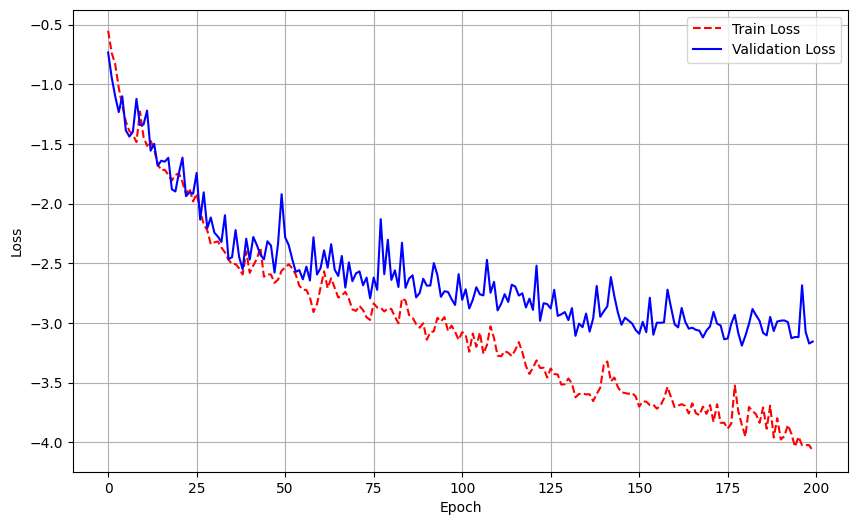

In [1]:
from utils.plot import save_graph_tb_log_metrics

save_graph_tb_log_metrics(
    first_csv_path='checkpoints/train_rnn/Loss_Train.csv',
    second_csv_path='checkpoints/train_rnn/Loss_Validation.csv',
    name_ox='Epoch',
    name_oy='Loss',
    loc = 'upper right',
    pth_save='pics/Loss_Train_Val.png'
)

**Evaluation**

In [1]:
import argparse
import sys

import torch
# using torchaudio-metrics for evaluation
from torchmetrics.audio import SignalDistortionRatio
from torchmetrics.audio import ScaleInvariantSignalNoiseRatio
from tqdm.notebook import tqdm

from losses import sisnr_loss, sdr_loss
from utils.load_config import load_config  
from models import MODELS
from data.DiarizationDataset import DiarizationDataset
from utils.load_config import load_config 

parser = argparse.ArgumentParser()
parser.add_argument("-p", "--hparams", type=str, default="./configs/train_rnn.yml", help="hparams config file")
args, unknown = parser.parse_known_args()  # Игнорирует нераспознанные аргументы
cfg = load_config(args.hparams)

In [2]:
model_class = MODELS[cfg['xp_config']['model_type']]
model = model_class(**cfg['model'])
device = cfg['trainer']['device']
model.to(device)
datamodule = DiarizationDataset(**cfg['data']).setup(stage = 'eval')
test_dataloader = datamodule.test_dataloader()

Size of test set: 1495
Elapsed time 'setup': 00:00:01.13


In [3]:
weight = './weights/__DualPath_RNN_179_-3.1895.pt'
dicts = torch.load(weight, map_location=device, weights_only=False)
model.load_state_dict(dicts['model_state_dict'])

<All keys matched successfully>

In [4]:
model.eval()
running_sdr = 0.0
running_sisnr = 0.0
p_running_sisnr = 0.0
sdr = SignalDistortionRatio().to(device)
sisnr = ScaleInvariantSignalNoiseRatio().to(device)

for inputs, labels in tqdm(test_dataloader):
    '''
    batch = 1 spk = 2 time = 3200
    inputs: [batch, time] 
    outputs and labels: [torch.randn(batch, time) for _ in range(spk)]  
    expectention outputs and labels for torch audio-loss: torch.Size([batch, spk, time])
    '''
    inputs, labels = inputs.to(device), [l.to(device) for l in labels]
    temp_l = labels
    labels = torch.stack(labels, dim=1).to(device)
    
    with torch.no_grad():
        outputs = [s.detach() for s in model(inputs)]
        p_running_sisnr += sisnr_loss(outputs, temp_l).item()
        outputs = torch.stack(outputs, dim=1).to(device)
        sdr.update(outputs, labels)
        sisnr.update(outputs, labels)
    
num_batches = len(test_dataloader)
sdr_on_train = - sdr.compute().item()
sisnr_on_train = - sisnr.compute().item()
p_sisnr_on_train = p_running_sisnr / len(test_dataloader)

print('sdr', sdr_on_train)
print('sisnr', sisnr_on_train)
print('custom sisnr', p_sisnr_on_train)

  0%|          | 0/748 [00:00<?, ?it/s]

sdr -0.016878711059689522
sisnr 1.6907145977020264
custom sisnr -6.543299086790353


##### G

In [3]:
import torch
from losses import sdr_loss
from torchmetrics.audio import PermutationInvariantTraining
from torchmetrics.functional.audio import signal_distortion_ratio
from torchmetrics.audio import SignalDistortionRatio

from losses import sisnr_loss
from torchmetrics.audio import ScaleInvariantSignalNoiseRatio

seed = 42
torch.manual_seed(seed)

batch = 1
spk = 2
time = 3200
sample_mix = [torch.randn(batch, time) for _ in range(spk)]
sample_refs = [torch.randn(batch, time) for _ in range(spk)]

# Функция для смешивания тензоров с заданной схожестью
def mix_tensors_with_similarity(tensor1, tensor2, unsimilarity=0.05):
    # Векторная интерполяция между tensor1 и tensor2
    # similarity - это коэффициент для интерполяции
    return unsimilarity * tensor1 + (1 - unsimilarity) * tensor2

# Применяем смешивание для всех спикеров
sample_mix_similar = [
    mix_tensors_with_similarity(m, r, unsimilarity=0.99)
    for m, r in zip(sample_mix, sample_refs)
]

sample_mix = sample_mix_similar

# Преобразуем sample_mix и sample_refs в тензоры размерности [batch, spk, time]
sample_mix_tensor = torch.stack(sample_mix, dim=1)  # по оси 1 (spk) ожидаемый вывод: torch.Size([1, 2, 3200])
sample_refs_tensor = torch.stack(sample_refs, dim=1)  # по оси 1 (spk)  # ожидаемый вывод: torch.Size([1, 2, 3200])

pit = PermutationInvariantTraining(signal_distortion_ratio, mode="speaker-wise", eval_func="max")
print('taudio:', - pit(sample_mix_tensor, sample_refs_tensor)) # Warining "-" minus before
sdr = SignalDistortionRatio()
print('another taudio:', - sdr(sample_mix_tensor, sample_refs_tensor)) # Warining "-" minus before
# print('my sdr:', sdr_loss(sample_mix, sample_refs), '\n')
print('')


print('my sisnr:', sisnr_loss(sample_mix, sample_refs).item())
sisnr = ScaleInvariantSignalNoiseRatio()
sisnr.update(sample_mix_tensor, sample_refs_tensor)
TEMP = sisnr.compute()
print('sisnr taudio:', - TEMP.item()) # Warining "-" minus before

taudio: tensor(7.6906)
another taudio: tensor(7.6906)

my sisnr: 32.48772430419922
sisnr taudio: 32.48772430419922
